# Crunching a 1024 packet log

## Importing 

And setting up the big constants

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
import binascii
# For videos
import subprocess
matplotlib.use('Agg')
from PIL import Image
# Constats
RAWDATA_LINE_IN_FRAME = 128
RAWDATA_SAMPLE_IN_LINE = 512

/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:1352: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Creating the video

We can open the data/video.data file and check that we have 1024 lines of 1400 bytes

In [2]:
RawData = []
DataName = "20170404-potatoes"
with open('data/'+DataName+'.data') as fp:
    for line in fp:
	if ":5002 " in line:
	        RawData.append(line.strip().split(":5002 ")[1])

print(len(RawData))
LenOfLines = len(RawData[0])

print(LenOfLines) # 2800 items
#print len(bin(int(RawData[0], 16))[2:])
# Tables of images are : 65536 points long


1024
2800


## Creating the video file

We can start with recreating the binary values for each point and check how many points we have. We should have 1024x1400

In [3]:
Line = []
BegLines = []

for j in range(len(RawData)):
    Data = RawData[j]
    for i in range(LenOfLines/2):
        Line.append(int(Data[2*i]+Data[2*i+1], 32))
print(len(Line))

1433600


## Let's find out where the lines start

We'll see that there's a pattern at the beginning of each line.. so we can know where each line starts, and check the 30 first points of a random line. The first 10 points represent the pattern.

21 images in this sequence


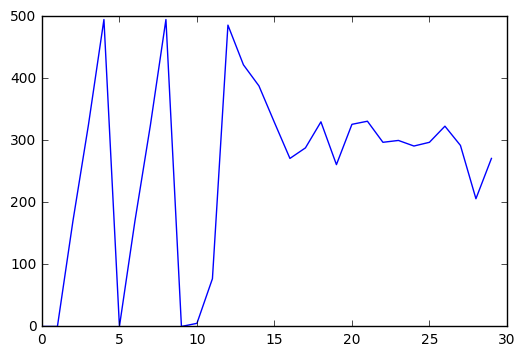

In [4]:
BegLines=[]
for pos in range(len(Line)-2):
        if (Line[pos] == 170):
            if (Line[pos+1] == 325):
                if (Line[pos+4] == 170):
                    if (Line[pos+5] == 325):
                            #print(str(pos)+" - "+str(Line[pos]))
                            BegLines.append(pos)
#print(len(BegLines))
#print(BegLines)
NbImages = (int)(len(BegLines)/RAWDATA_LINE_IN_FRAME)
print(str(NbImages)+" images in this sequence")
#print(21*128*512)
ref = BegLines[45]-2
kk = 128*2+2
#print(BegLines[kk]-BegLines[kk+1])
plt.plot(Line[ref:ref+30])

plt.show()

## Creating the video array

The video will have as many images as we have captured, based on images of RAWDATA_LINE_IN_FRAME x RAWDATA_SAMPLE_IN_LINE.

Let's check the size of it at the end.

In [5]:
video = []

for k in range(NbImages):
    image = []
    for i in range(RAWDATA_LINE_IN_FRAME):
        line = []
        for j in range(RAWDATA_SAMPLE_IN_LINE):
            line.append(Line[BegLines[i+RAWDATA_LINE_IN_FRAME*k]+j]/2)

        image.append(line)
    video.append(image)
    
image = np.array(image).astype(float)
video.append(image)
print(image.shape)

(128, 512)


In [6]:
def ShowImage(ImageToPlot):
    plt.figure(figsize=(4, 4))
    plt.gray()
    plt.imshow(ImageToPlot.reshape(ImageToPlot.shape), aspect='auto')
    plt.show()

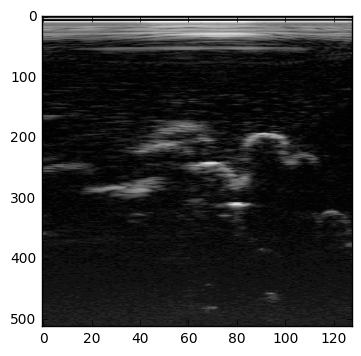

In [7]:
ShowImage(np.transpose(video[0]))

### Saving the set of image 

As a video, using ffmpeg, and settinb the framerate -- [see the video](video/20170404-potatoes.avi).

In [11]:
VideoFilName = "./video/"+DataName+'.avi'
VideoFrameRate = 12

cmdstring = ('ffmpeg',
             '-y',
             '-r', '%d' % VideoFrameRate,
             '-f','image2pipe',
             '-vcodec', 'mjpeg',
             '-i', 'pipe:', 
             '-vcodec', 'libxvid',
             VideoFilName
             )
p = subprocess.Popen(cmdstring, stdin=subprocess.PIPE, shell=False)

for i in range(NbImages):
    im = Image.fromarray(np.uint8(np.transpose(video[i])))
    p.stdin.write(im.tobytes('jpeg','L'))
    #p.communicate(im.tostring('jpeg','L'))

p.stdin.close()

### which yields

![a short video](video/20170404-potatoes.gif)

## Next steps

Some other stuff to do? Sure! In short

* Command electronicanlly the start / end
* Send gain
* Get probe details
* Do the scan conversion
* ... and so much more !